In [19]:
from rpy2 import robjects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import multiprocessing as mp
import pandas as pd
import numpy as np
import datetime
import yaml
import os
# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# Suppress R warnings in python:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)
rain     = pd.read_csv('haiti-data/proj/rainfall.csv', index_col = 0, parse_dates = True)

compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases', 'C',
                 "VSd", "VRI1d", "VRI2d", "VRI3d", "VRA1d", "VRA2d", "VRA3d",
                 "VSdd", "VRI1dd", "VRI2dd", "VRI3dd", "VRA1dd", "VRA2dd", "VRA3dd",
                 "VSd_alt", "VRI1d_alt", "VRI2d_alt", "VRI3d_alt", "VRA1d_alt", "VRA2d_alt", "VRA3d_alt",
                 "VSdd_alt", "VRI1dd_alt", "VRI2dd_alt", "VRI3dd_alt", "VRA1dd_alt", "VRA2dd_alt", "VRA3dd_alt"]

departements = ['Artibonite','Centre','Grande_Anse','Nippes','Nord','Nord-Est','Nord-Ouest','Ouest','Sud','Sud-Est']

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,20)

index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')

def make_genuine_mobility_file():
    covar_init = pd.concat([cases[t_start:]]*6, ignore_index=True)[0:-506]
    covar_init.index = pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT')
    covar_init.to_csv('covar_mob.csv', index_label='date')
    return covar_init

class VaccinationScenario():
    def __init__(self, course_year, percent_completely_unvaccinated, percent_onedose, percent_twodoses, ve, not_dep = []):
        pop = {'Artibonite':1727524,
        'Centre':746236,
        'Grande_Anse':468301,
        'Nippes':342525,
        'Nord':1067177,
        'Nord-Est':393967,
        'Nord-Ouest':728807,
        'Ouest':4029705,
        'Sud':774976,
        'Sud-Est':632601}
        ocv_order = ['Centre', 'Artibonite','Ouest','Nord-Ouest','Nord','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
        self.t_vacc_start = {}
        self.t_vacc_end = {}
        self.p1d_reg = {}
        self.r_v_year = {}
        self.ve = ve
        self.not_dep = not_dep

        #20% completely unvaccinated, 10% one-dose only, 70% two doses
        t_init = datetime.date(2019,1,12)
        days_per_departement = int((course_year*365)/len(ocv_order))

        for i, dp in enumerate(ocv_order):
            if dp not in not_dep:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = percent_onedose/(percent_onedose + percent_twodoses)
                self.r_v_year[dp] = pop[dp]*(100-percent_completely_unvaccinated)/100/days_per_departement * 365.25

            else:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = 0
                self.r_v_year[dp] =0
def run_sim():
    # see second answer of https://stackoverflow.com/questions/25175530/can-rpy2-code-be-run-in-parallel on why it starts different 
    # R instances
    r_source = robjects.r['source'];
    dept_data = {}
    r_options = robjects.r['options']
    r_options(warn=-1)
    robjects.r('scenario     <- "' + scenario_str + '"')
    robjects.r('nsim         <- '  + str(nsim))
    robjects.r('t_vacc_start <- list()')
    robjects.r('t_vacc_end <- list()')
    robjects.r('p1d_reg <- list()')
    robjects.r('r_v_year <- list()')


    for dp in departements:
        robjects.r('t_vacc_start${} <- "'.format(dp.replace('-','_')) + str(scenario.t_vacc_start[dp]) + '"')
        robjects.r('t_vacc_end${}   <- "'.format(dp.replace('-','_')) + str(scenario.t_vacc_end[dp]) + '"')
        robjects.r('p1d_reg${}     <- '.format(dp.replace('-','_'))  + str(scenario.p1d_reg[dp]))
        robjects.r('r_v_year${}     <- '.format(dp.replace('-','_'))  + str(scenario.r_v_year[dp]))
    robjects.r('cases_ext    <- '.format(dp)  + str(scenario.ve))
    r_source('/Users/chadi/Documents/phd/haiti-ocv-pomp/scripts/forecast_all_dept.R')

def save_result(to_save, scenario_str, folder_name = ''):
    csv_all_q50 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

    csv_all_q05 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

    csv_all_q95 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)


    for dp in dept_avail:
        csv_all_q50[dp] = to_save[dp]['cases']['q50']
        csv_all_q95[dp] = to_save[dp]['cases']['q95']
        csv_all_q05[dp] = to_save[dp]['cases']['q05']
        
    csv_all_q05.to_csv(folder_name + scenario_str + '_q05.csv', index_label='date')
    csv_all_q95.to_csv(folder_name + scenario_str + '_q95.csv', index_label='date')
    csv_all_q50.to_csv(folder_name + scenario_str + '_q50.csv', index_label='date')
    pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], 
              axis = 1, keys = ['q05', 'q50', 'q95']).to_csv(folder_name + scenario_str + '_national.csv', index_label='date')

    for dp in dept_avail:
        csv_all_q50[dp] = to_save[dp]['C']['q50']
        csv_all_q95[dp] = to_save[dp]['C']['q95']
        csv_all_q05[dp] = to_save[dp]['C']['q05']
        
    csv_all_q05.to_csv(folder_name + scenario_str + '_q05_s.csv', index_label='date')
    csv_all_q95.to_csv(folder_name + scenario_str + '_q95_s.csv', index_label='date')
    csv_all_q50.to_csv(folder_name + scenario_str + '_q50_s.csv', index_label='date')
    pd.concat([csv_all_q05.sum(axis=1), csv_all_q50.sum(axis=1), csv_all_q95.sum(axis=1)], 
              axis = 1, keys = ['q05', 'q50', 'q95']).to_csv(scenario_str + '_national_s.csv', index_label='date')


scenarios_df = pd.read_csv('haiti-data/scenarios.csv', index_col = 0)

scenarios = {}
for sid, row in scenarios_df.iterrows():
    not_dep = []
    course_year = 2
    if (row['Roll-out'] == 2):
        not_dep = ['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
    elif (row['Roll-out'] == 3):
        course_year = 5
    elif (row['Roll-out'] == 4):
        not_dep = ['Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
        
    percent_completely_unvaccinated = 0
    percent_onedose = 0
    percent_twodoses = 0
    
    if (row['Coverage'] == 1):
        percent_completely_unvaccinated = 20
        percent_onedose = 10
        percent_twodoses = 70
    elif (row['Coverage'] == 2):
        percent_completely_unvaccinated = 40
        percent_onedose = 20
        percent_twodoses = 40
    elif (row['Coverage'] == 3):
        percent_completely_unvaccinated = 3.33
        percent_onedose = 1.67
        percent_twodoses = 95
    ve = row['VE']
            
    #if (row['Priority'] == 1):
    if True:
        scenarios['S' + str(sid)] = VaccinationScenario(course_year, 
                                                      percent_completely_unvaccinated, 
                                                      percent_onedose, 
                                                      percent_twodoses,
                                                      ve,
                                                      not_dep)

S0 = VaccinationScenario(50, 
                         99.9999999, 
                         0.00000001, 
                         0.00,
                         ve = 1)
scenarios['S0'] = S0
    
nsim = 100

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


In [15]:
't_vacc_start${} <- "'.format('Nord-Est')

't_vacc_start$Nord-Est <- "'

#### Forecasting with no vaccination

In [23]:
all_data = {}
pars_dic = {}

scenario_str = 'S0'
scenario = scenarios[scenario_str]

run_sim()

R[write to console]: Parsed with column specification:
cols(
  date = col_date(format = ""),
  Artibonite = col_double(),
  Centre = col_double(),
  Grande_Anse = col_double(),
  Nippes = col_double(),
  Nord = col_double(),
  `Nord-Est` = col_double(),
  `Nord-Ouest` = col_double(),
  Ouest = col_double(),
  Sud = col_double(),
  `Sud-Est` = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  date = col_date(format = ""),
  Artibonite = col_double(),
  Centre = col_double(),
  Grande_Anse = col_double(),
  Nippes = col_double(),
  Nord = col_double(),
  `Nord-Est` = col_double(),
  `Nord-Ouest` = col_double(),
  Ouest = col_double(),
  Sud = col_double(),
  `Sud-Est` = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  date = col_date(format = ""),
  Artibonite = col_double(),
  Centre = col_double(),
  Grande_Anse = col_double(),
  Nippes = col_double(),
  Nord = col_double(),
  `Nord-Est` = col_double(),
  `Nord-Ouest` = col_dou

RRuntimeError: Error in as.Date.default(t_vacc_start$dp) : 
  incapable de convertir 't_vacc_start$dp' dans la classe "Date"
Calls: <Anonymous> ... dateToYears -> julian -> as.Date -> as.Date.default


### Extracting best performing parameters

In [26]:
    print('scenario     <- "' + scenario_str + '"')
    print('nsim         <- '  + str(nsim))
    print('t_vacc_start <- list()')
    print('t_vacc_end <- list()')
    print('p1d_reg <- list()')
    print('r_v_year <- list()')


    for dp in departements:
       print('t_vacc_start${} <- "'.format(dp.replace('-','_')) + str(scenario.t_vacc_start[dp]) + '"')
       print('t_vacc_end${}   <- "'.format(dp.replace('-','_')) + str(scenario.t_vacc_end[dp]) + '"')
       print('p1d_reg${}     <- '.format(dp.replace('-','_'))  + str(scenario.p1d_reg[dp]))
       print('r_v_year${}     <- '.format(dp.replace('-','_'))  + str(scenario.r_v_year[dp]))
       print('cases_ext    <- '.format(dp)  + str(scenario.ve))

scenario     <- "S0"
nsim         <- 100
t_vacc_start <- list()
t_vacc_end <- list()
p1d_reg <- list()
r_v_year <- list()
t_vacc_start$Artibonite <- "2024-01-11"
t_vacc_end$Artibonite   <- "2029-01-09"
p1d_reg$Artibonite     <- 1.0
r_v_year$Artibonite     <- 0.0003457414265972485
cases_ext    <- 1
t_vacc_start$Centre <- "2019-01-12"
t_vacc_end$Centre   <- "2024-01-11"
p1d_reg$Centre     <- 1.0
r_v_year$Centre     <- 0.00014934941524298614
cases_ext    <- 1
t_vacc_start$Grande_Anse <- "2064-01-01"
t_vacc_end$Grande_Anse   <- "2068-12-30"
p1d_reg$Grande_Anse     <- 1.0
r_v_year$Grande_Anse     <- 9.372434525767405e-05
cases_ext    <- 1
t_vacc_start$Nippes <- "2049-01-04"
t_vacc_end$Nippes   <- "2054-01-03"
p1d_reg$Nippes     <- 1.0
r_v_year$Nippes     <- 6.855191716307418e-05
cases_ext    <- 1
t_vacc_start$Nord <- "2039-01-07"
t_vacc_end$Nord   <- "2044-01-06"
p1d_reg$Nord     <- 1.0
r_v_year$Nord     <- 0.0002135815759501876
cases_ext    <- 1
t_vacc_start$Nord_Est <- "2054-01-03"
t_vacc

In [7]:
print(params_disp)

                betaB   cas_def  cases_ext   epsilon       foi_add  gammaA  \
Artibonite   0.516191  0.464975        1.0  0.975027  1.530994e-06     2.0   
Sud-Est      1.384372  0.460000        1.0  0.975027  6.105491e-07     2.0   
Nippes       2.999928  0.460000        1.0  0.975027  3.056857e-07     2.0   
Nord-Est     3.248645  0.460000        1.0  0.975027  8.209611e-07     2.0   
Ouest        0.106151  0.460000        1.0  0.975027  1.029080e-07     2.0   
Centre       1.977686  0.460000        1.0  0.975027  1.065046e-05     2.0   
Nord         0.589541  0.460000        1.0  0.975027  5.319736e-07     2.0   
Sud          1.305966  0.460000        1.0  0.975027  1.030357e-06     2.0   
Nord-Ouest   1.141691  0.460000        1.0  0.975027  5.855759e-07     2.0   
Grande_Anse  2.823539  0.460000        1.0  0.975027  8.762740e-07     2.0   

             gammaI         k   lambdaR      mu_B         r    rhoA    rhoI  \
Artibonite      2.0  101.2216  0.277424  2.742176  0.313604  2

In [297]:
all_data['Ouest']['cases'][:datetime.date(2015,7,1)] = np.nan

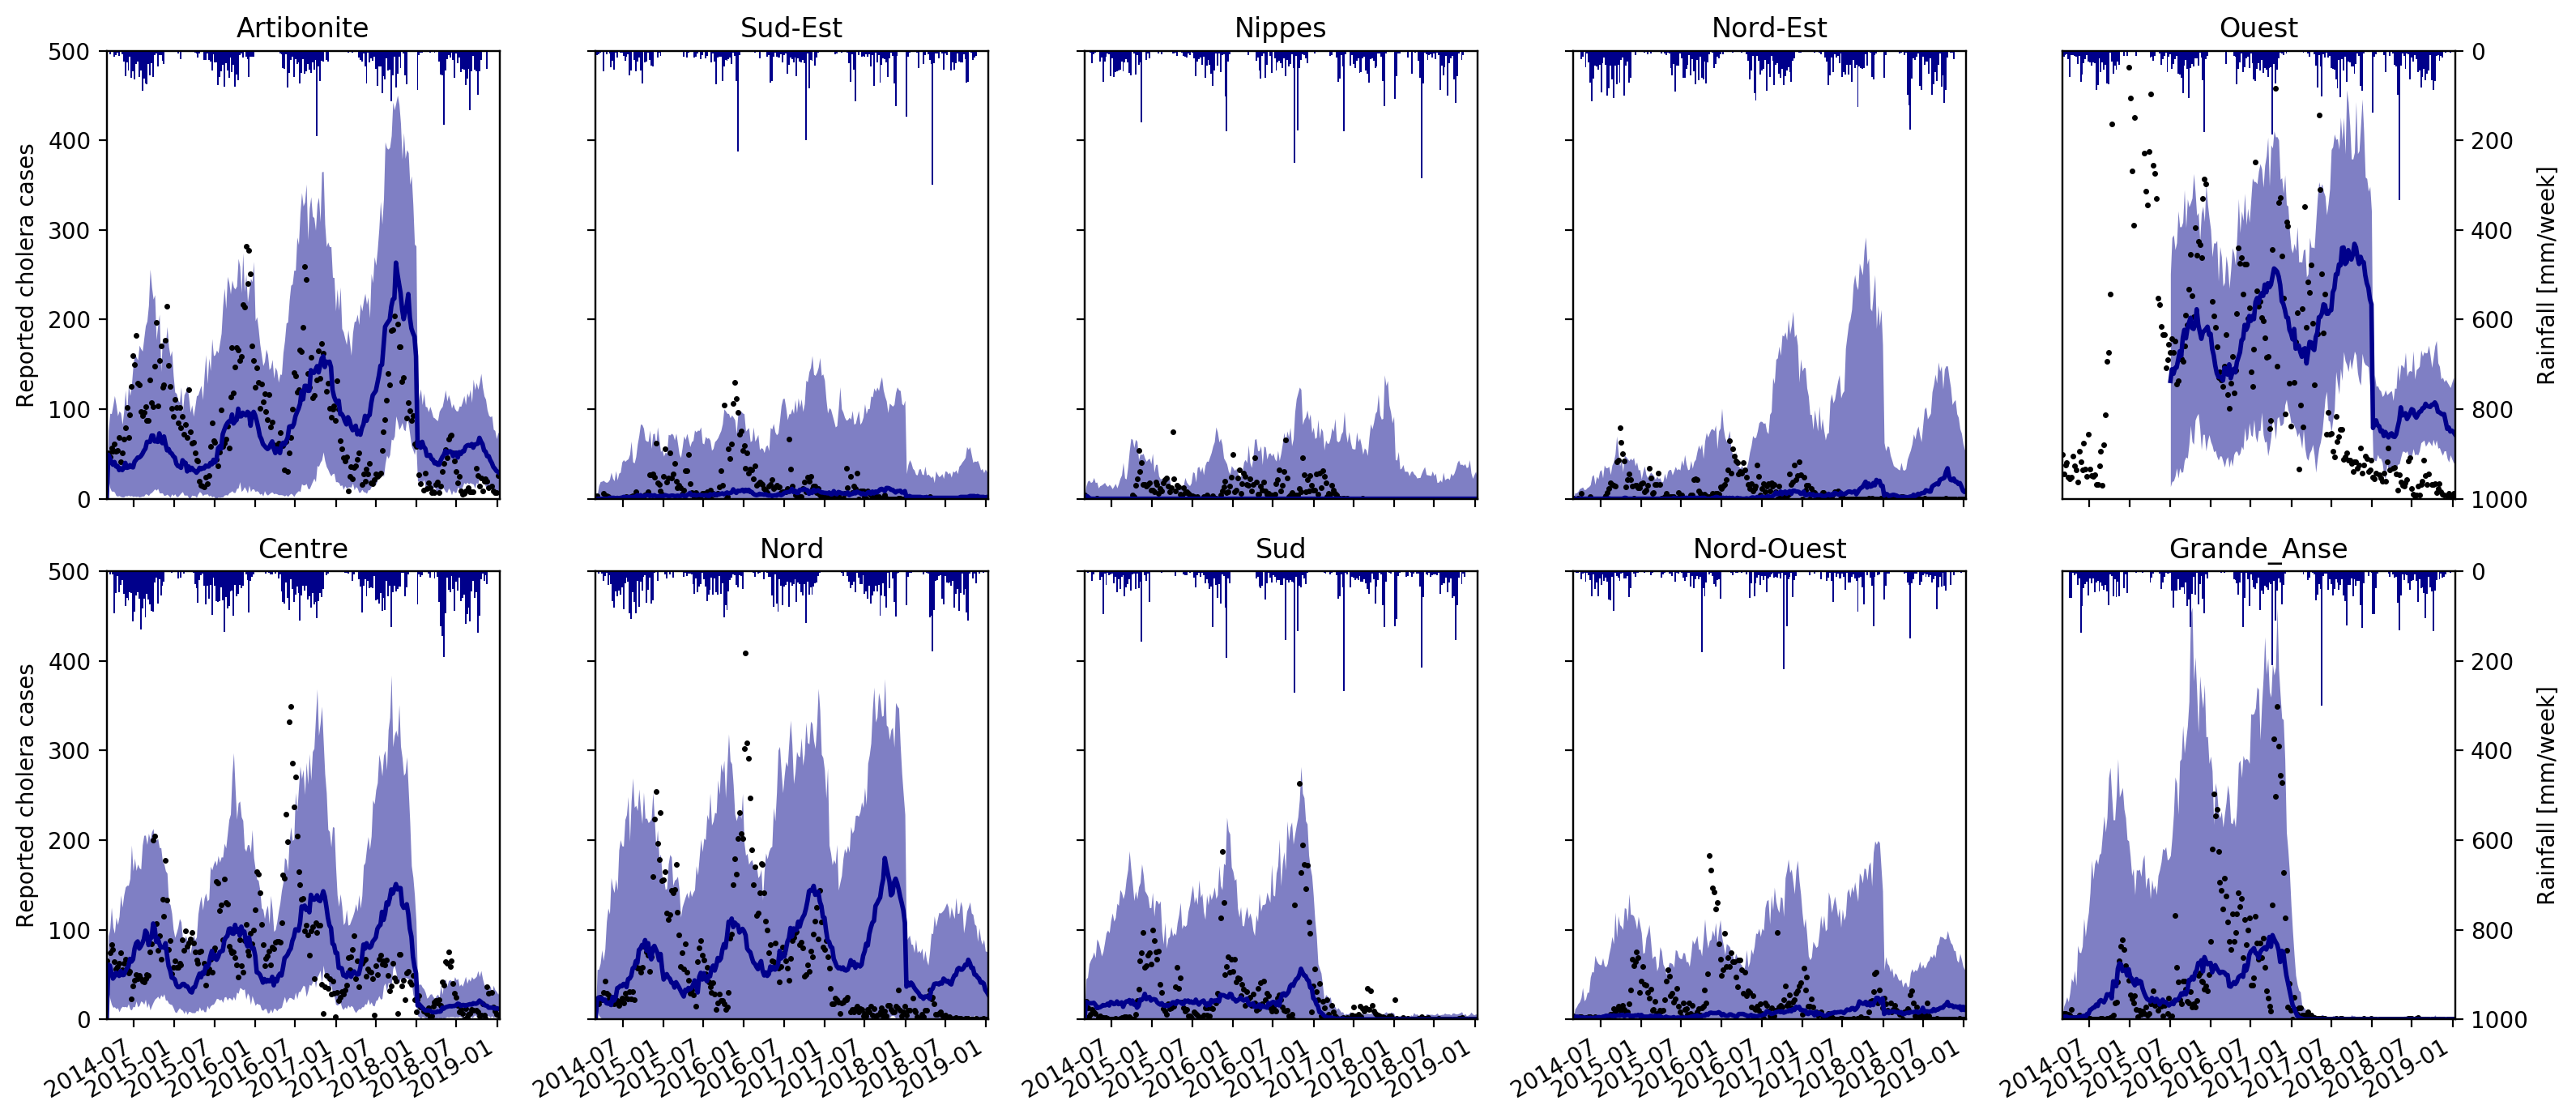

In [396]:
ti = input_parameters['t_start']
tf = input_parameters['t_end']
#tf = t_for

fig, axes = plt.subplots((len(dept_avail))//5, 5, figsize=(16,7), squeeze = True, dpi = 200 , sharex='col', sharey='row');
fig.patch.set_facecolor('white')
axes = axes.flat;
for i, dp in enumerate(dept_avail):

    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-',color='black', linewidth=0, markersize=3 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'][ti:tf].index, all_data[dp]['cases']['q05'][ti:tf], all_data[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'darkblue', linewidth = 0)
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 2, color = 'darkblue')
    axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0, 500)
    axt.set_ylim(1000, 0)
    #axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    if i%5 == 4:
        axt.set_ylabel('Rainfall [mm/week]')
        axes[i].get_yaxis().set_visible(False)
        
    elif i%5 == 0:
        axes[i].set_ylabel('Reported cholera cases')
    if i%5 != 4:
        axt.get_yaxis().set_visible(False)
    #axes[i].legend()
    
for ax in axes:
    ax.label_outer()

fig.autofmt_xdate()
fig.tight_layout()


### Repartition in the differents compartiments for one departement 

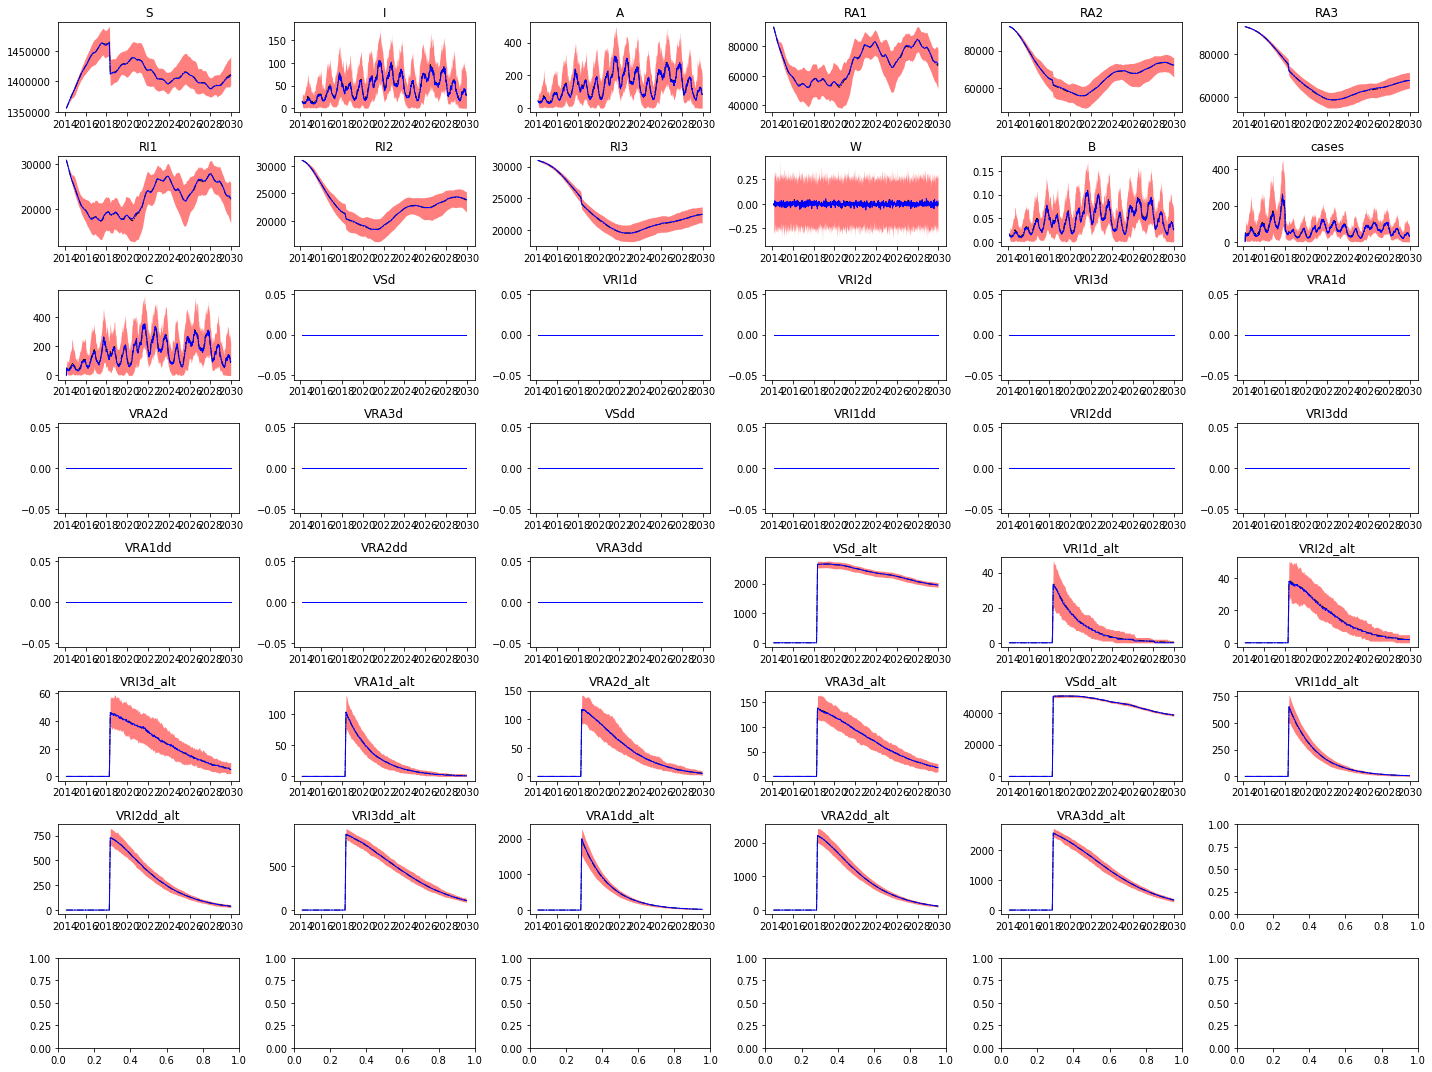

In [301]:
dp = 'Artibonite'
ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for
fig, axes = plt.subplots((len(compartments))//5, 6, figsize=(20,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'][ti:tf].index, all_data[dp][comp]['q05'][ti:tf], all_data[dp][comp]['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'][ti:tf], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    #axes[i].legend()
    #axes[i].set_ylim(0)
    
fig.tight_layout()

#### Vaccination scenario

In [455]:
scenario_str = 'S2'
scenario = scenarios[scenario_str]


### Vaccination without mobility to build the mobility file

In [ ]:
all_data_vacc = {}

make_genuine_mobility_file()
with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, _, _ in pool.imap_unordered(run_sim, dept_avail):
        all_data_vacc[dp] = dept_data

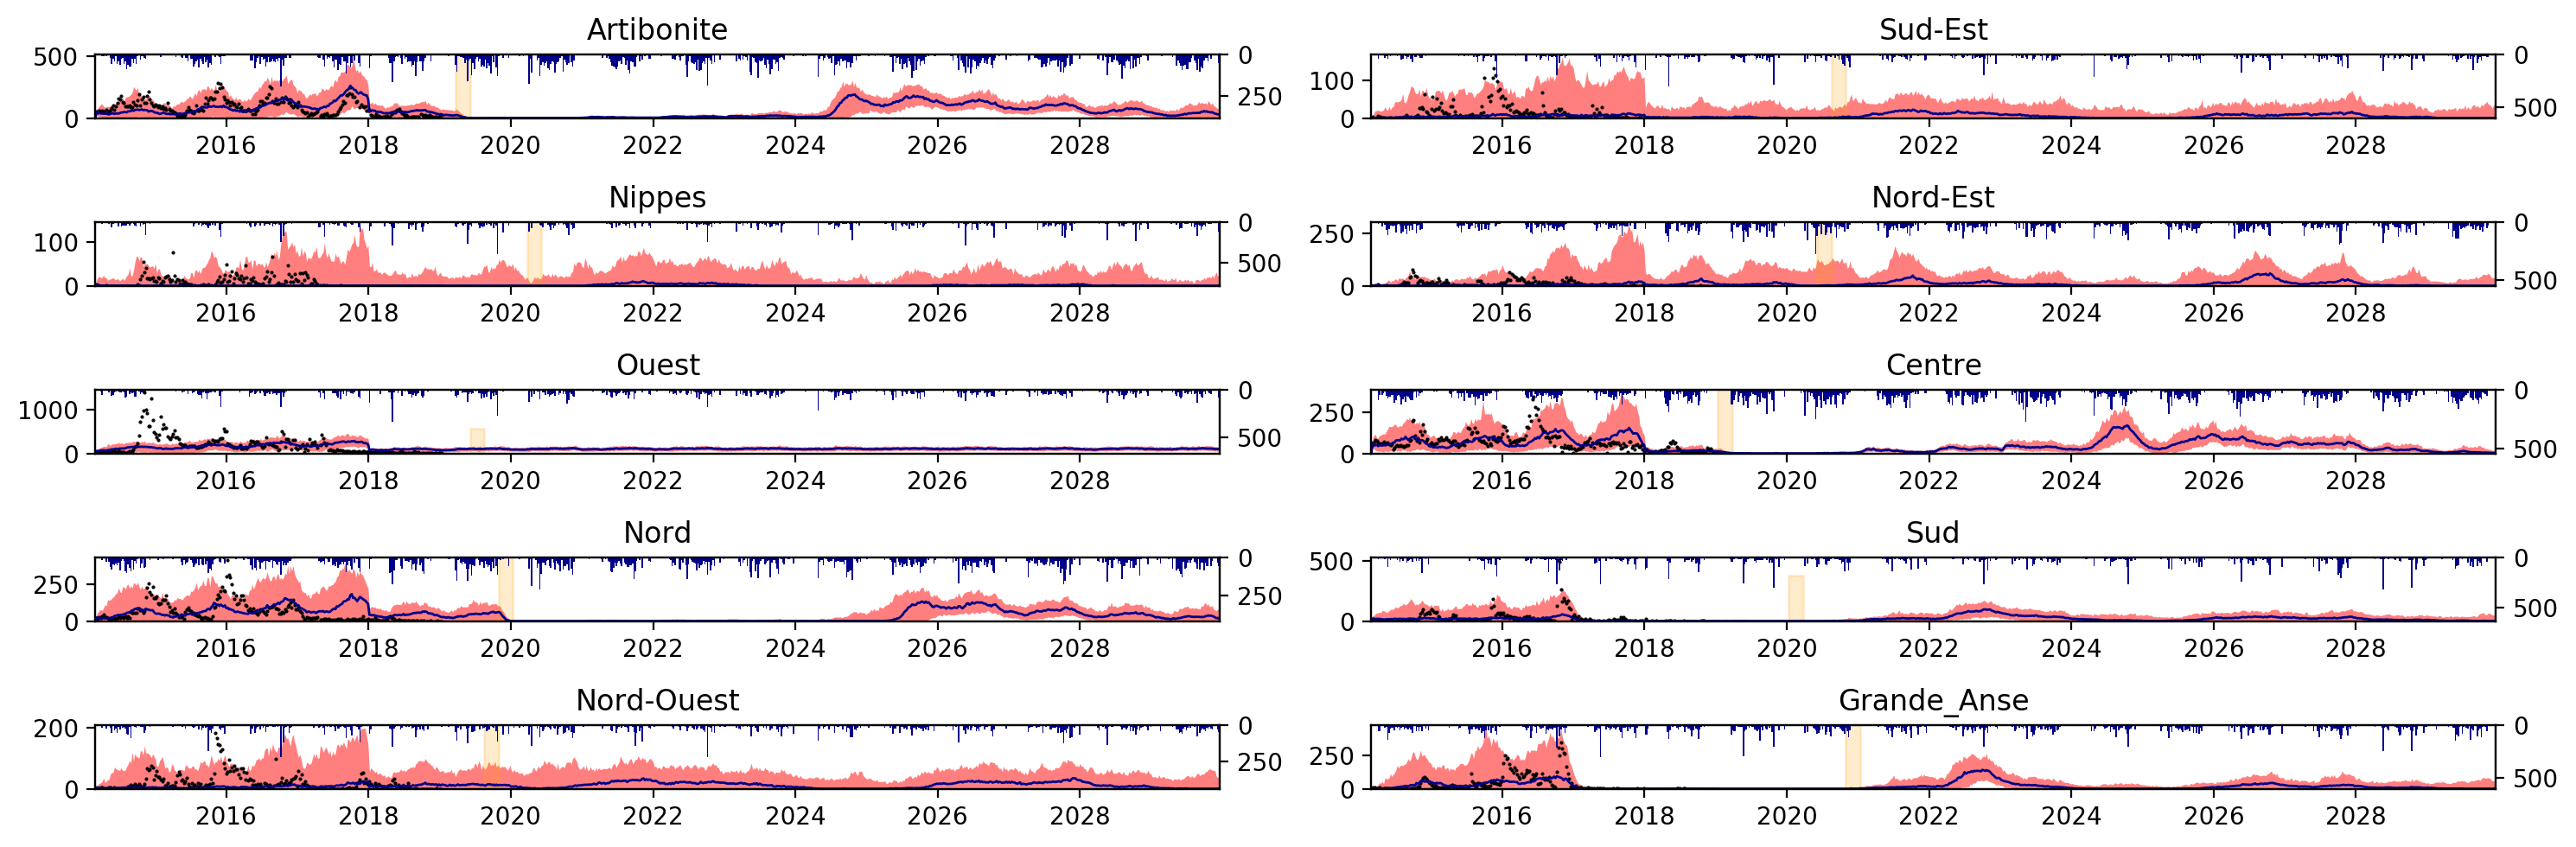

In [457]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,5), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'][ti:tf].index, all_data_vacc[dp]['cases']['q05'][ti:tf], all_data_vacc[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)    
    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

#### Take away mobility to make a mobility file

In [458]:
vacc_init = pd.DataFrame(np.nan, pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

cases_df =  pd.DataFrame(np.nan, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

covar_mob_novacc = make_genuine_mobility_file()

for dp in dept_avail:
    cases_df[dp] = all_data_vacc[dp]['cases']['q50'][scenario.t_vacc_start[dp]+datetime.timedelta(days = 90) : scenario.t_vacc_start[dp] + datetime.timedelta(days = 200)]

    if (sum(all_data_vacc[dp]['cases']['q50'][scenario.t_vacc_start[dp]: scenario.t_vacc_start[dp] + datetime.timedelta(days = 200)] == 0) >= 3):
        # No more cases at some point
        cases_df[dp] = 0


for dp in dept_name:
    if dp in dept_avail:
        vacc_init[dp] = covar_mob_novacc[dp][datetime.date(2010,10,23):scenario.t_vacc_start[dp]]   # 
        vacc_init[dp].fillna(cases_df[dp].mean(), inplace = True)
        print(dp, cases_df[dp].mean())
    else:
        vacc_init[dp] = covar_mob_novacc[dp]  #0
        
    
vacc_init.to_csv('vacc_init' + scenario_str +  '.csv', index_label='date')

Artibonite 0.0
Centre 0.0
Grande_Anse 0.0
Nippes 0.0
Nord 0.0
Nord-Est 0.0
Nord-Ouest 8.233333333333333
Ouest 105.71875
Sud 0.0
Sud-Est 4.1875


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


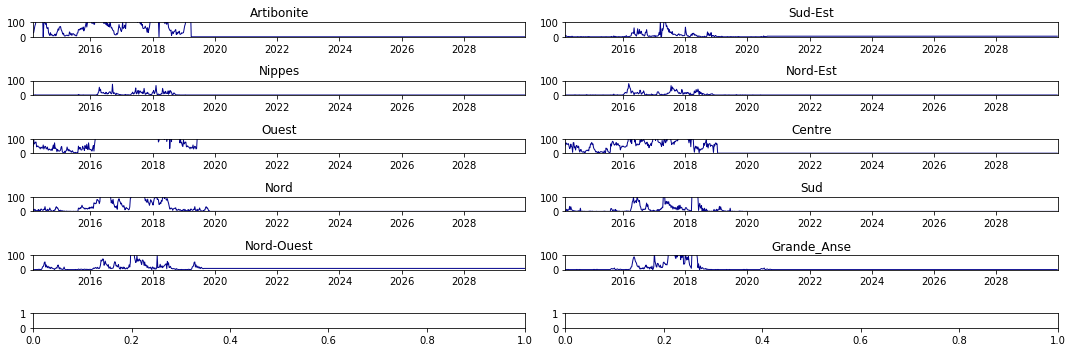

In [459]:
fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,5), squeeze = True);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axes[i].plot(vacc_init[dp], alpha = 5,linestyle='-', linewidth = 1, color = 'darkblue')
    #axes[i].plot(covar_init[dp], alpha = 1,linestyle='-', linewidth = 1, color = 'red')
    axes[i].set_title(dp)
    axes[i].set_ylim(0,100)
    axes[i].set_xlim(t_start, t_for)

fig.tight_layout()

### Projection with mobility

In [460]:
vacc_init = pd.read_csv('vacc_init' + scenario_str +  '.csv', index_col = 0, parse_dates = True)
vacc_init.to_csv('covar_mob.csv', index_label='date')

all_data_vacc_mob = {}

with mp.Pool(processes=n_proc) as pool:
    for dp, dept_data, _, _ in pool.imap_unordered(run_sim, dept_avail):
        all_data_vacc_mob[dp] = dept_data

R[write to console]: Parsed with column specification:
cols(
  .default = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double()
)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: See spec(...) for full column specifications.

R[write to console]: See spec(...) for full column specifications.

R[write to console]: See spec(...) for full column specifications.

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Joining, by = c("loglik", "loglik.se", "betaB", "foi_add", "sigma", "mu_B", "thetaI", "XthetaA", "lambdaR", "r", "gammaI", "gammaA", "rhoA", "XrhoI", "epsilon", "k", "std_W", "cas_def", "Rt

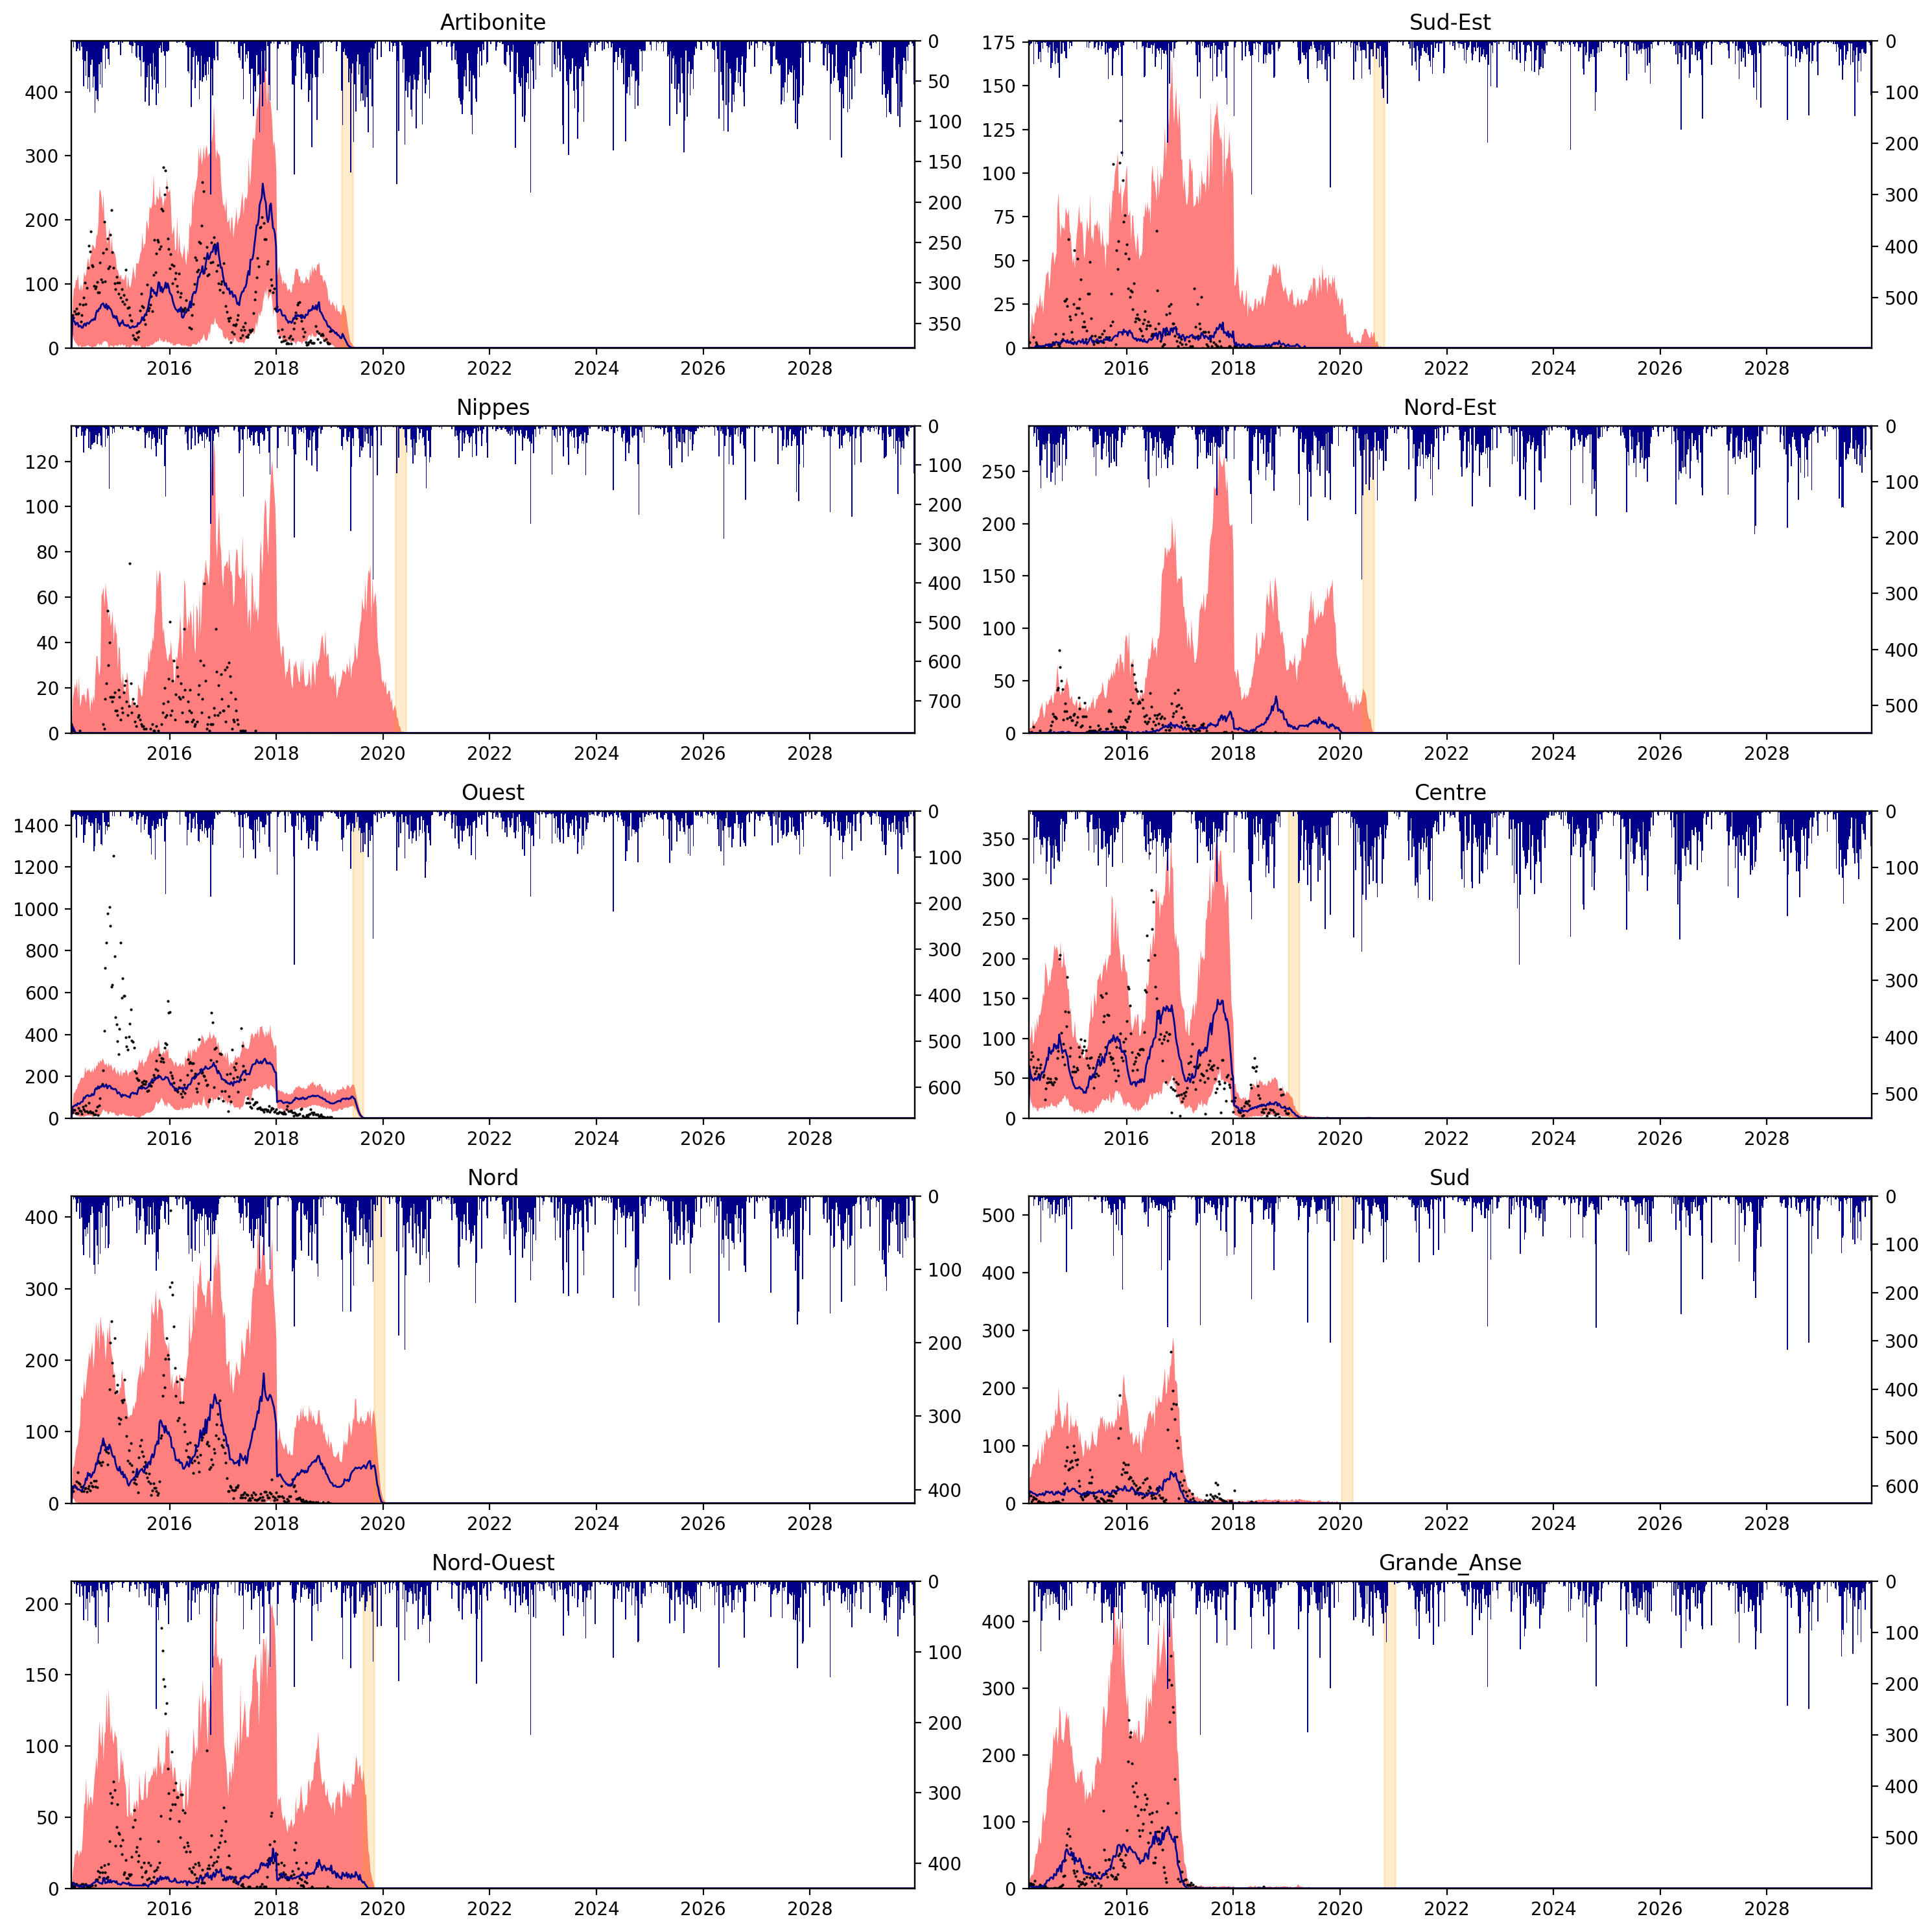

In [453]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,15), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc_mob[dp]['cases']['q05'][ti:tf].index, all_data_vacc_mob[dp]['cases']['q05'][ti:tf], all_data_vacc_mob[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc_mob[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)
    
    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    if dp not in scenario.not_dep:
        # convert to matplotlib date representation
        start = mdates.date2num(scenario.t_vacc_start[dp])
        end = mdates.date2num(scenario.t_vacc_end[dp])
        width = end - start
        rect = Rectangle((start, 0), width, 1000+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
        axes[i].add_patch(rect) 
        axes[i].add_artist(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/1.5

fig.tight_layout()

#### Comparison

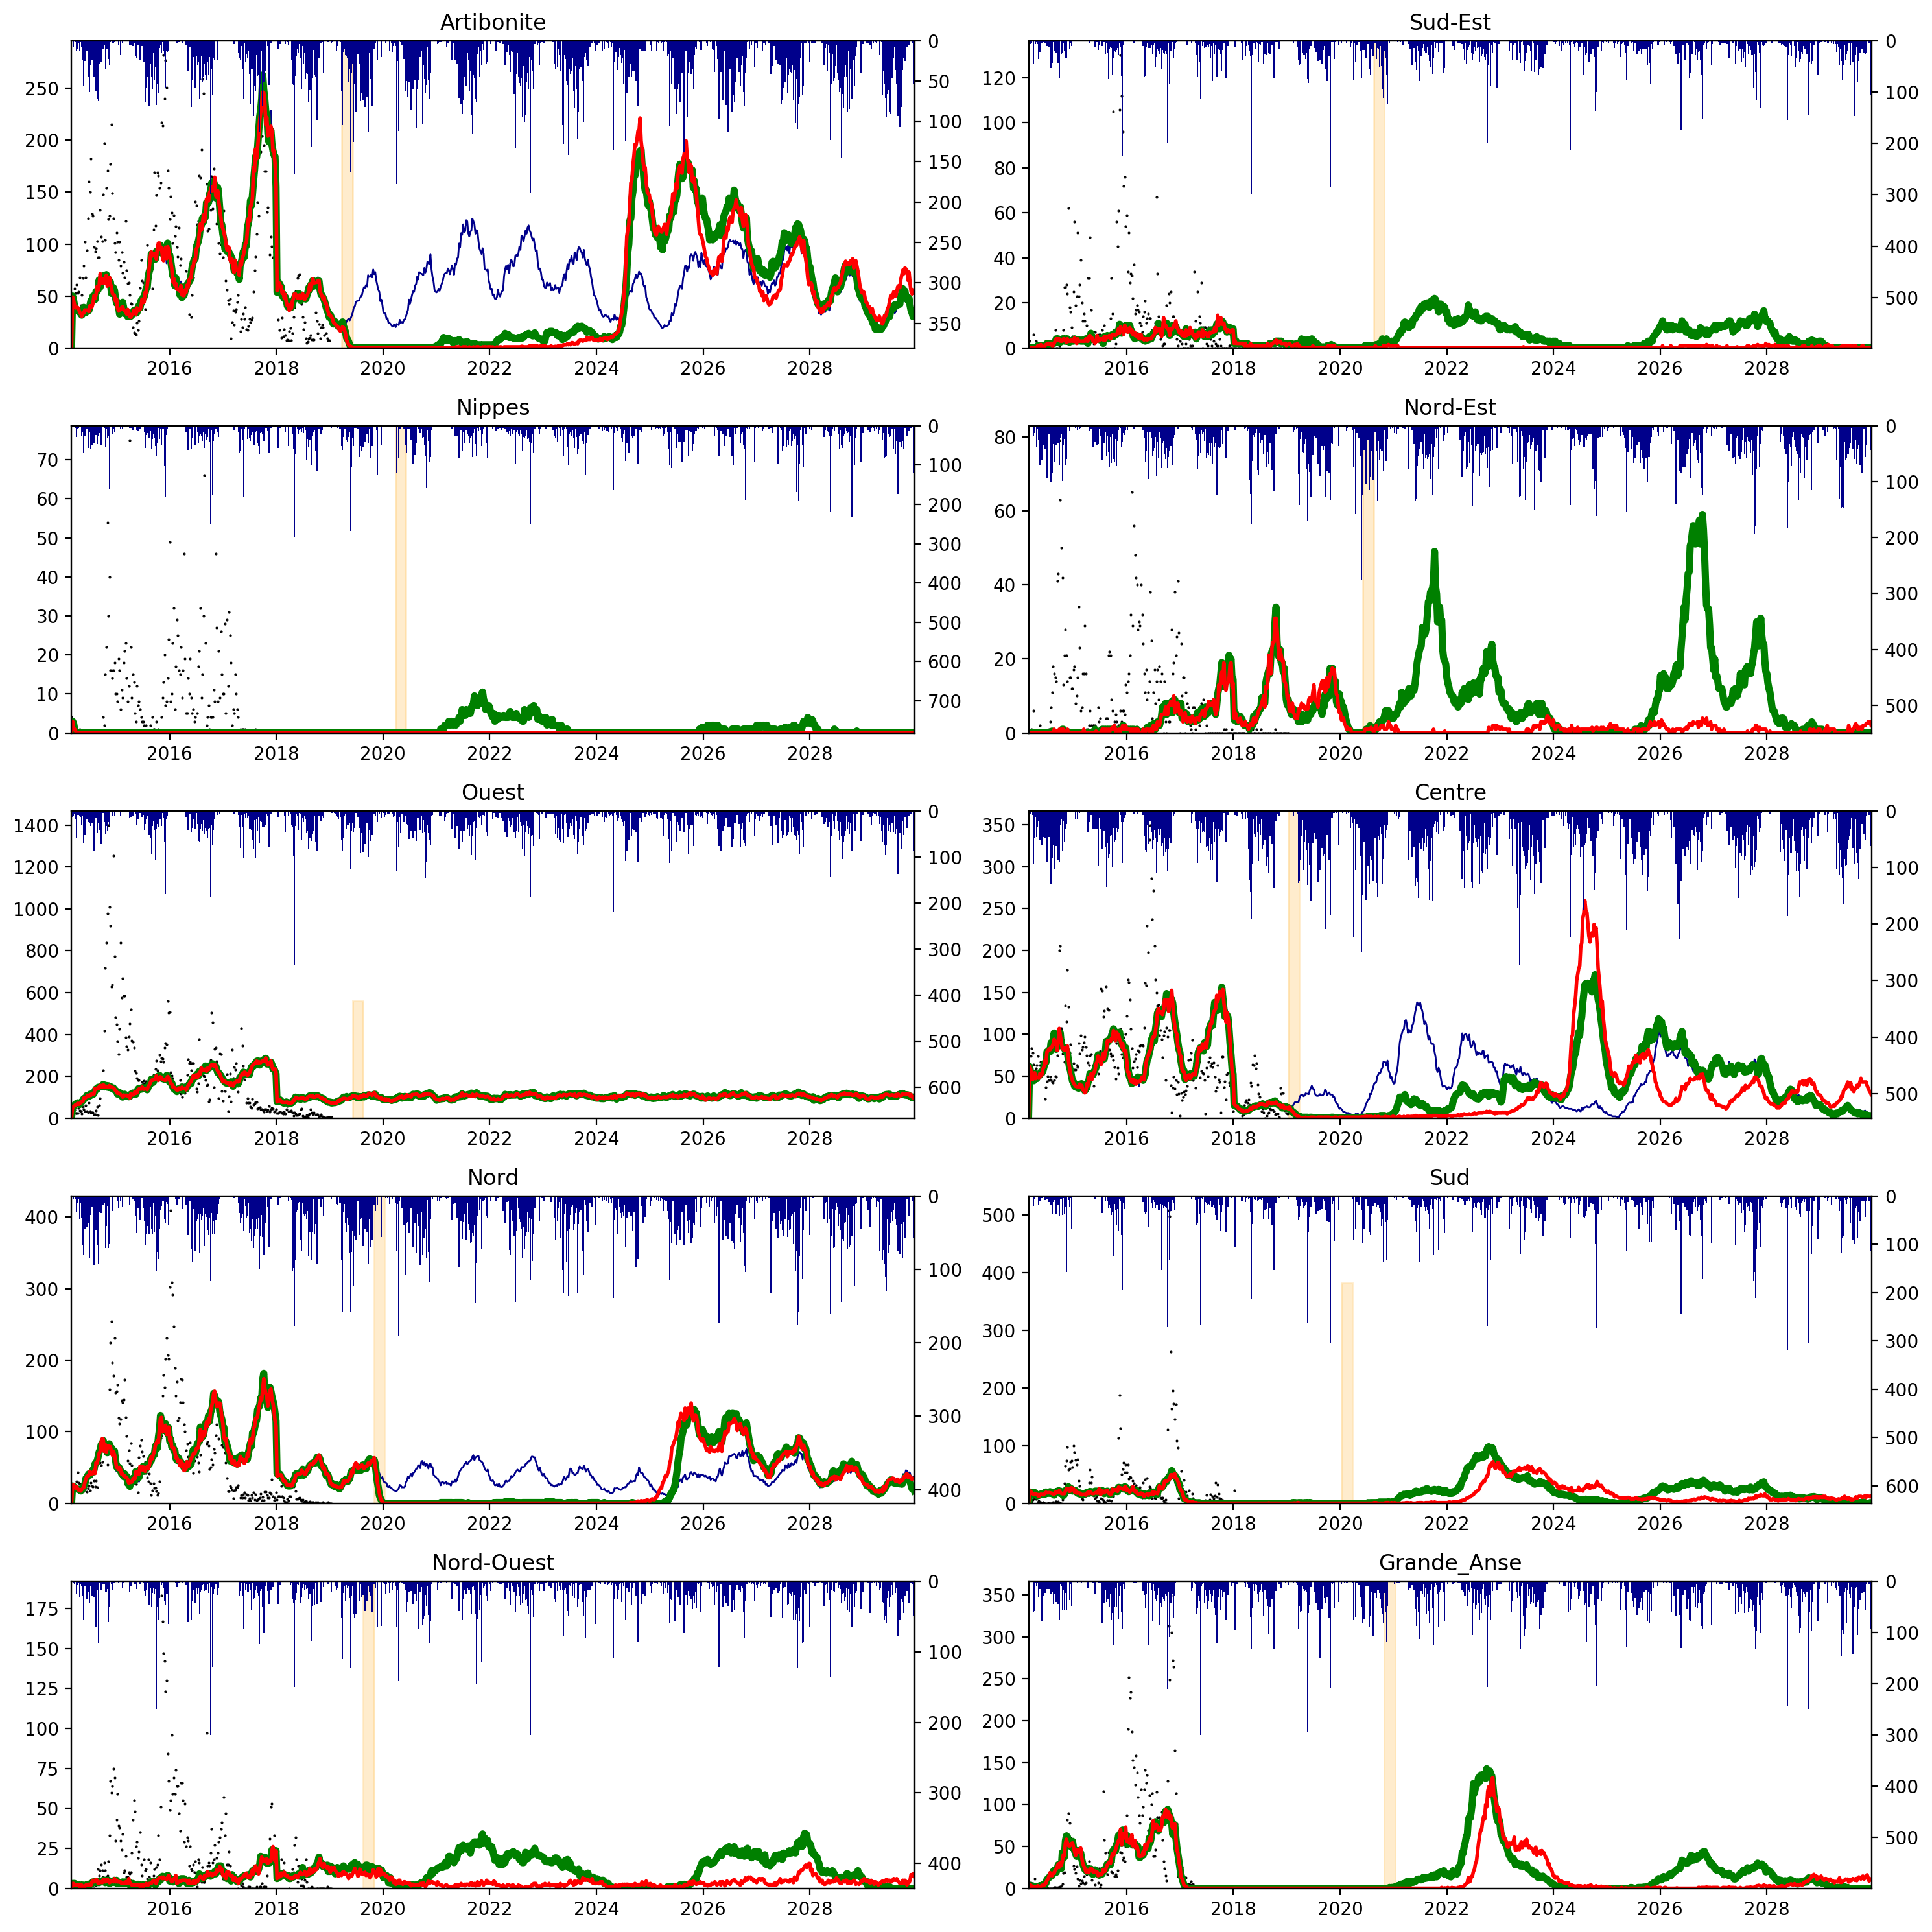

In [464]:
ti = input_parameters['t_start']
#ti = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,15), squeeze = True, dpi = 200);
axes = axes.flatten();
fig.patch.set_facecolor('white')

for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 )
    
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf],          alpha = 1, linestyle='-', linewidth = 1, color = 'darkblue')
    axes[i].plot(all_data_vacc[dp]['cases']['q50'][ti:tf],     alpha = 1, linestyle='-', linewidth = 4, color = 'green')
    axes[i].plot(all_data_vacc_mob[dp]['cases']['q50'][ti:tf], alpha = 1, linestyle='-', linewidth = 2, color = 'red')
    
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)    
    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5

fig.tight_layout()

## Nationwide plot

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  if __name__ == '__main__':


Text(0, 0.5, 'Reported cholera cases')

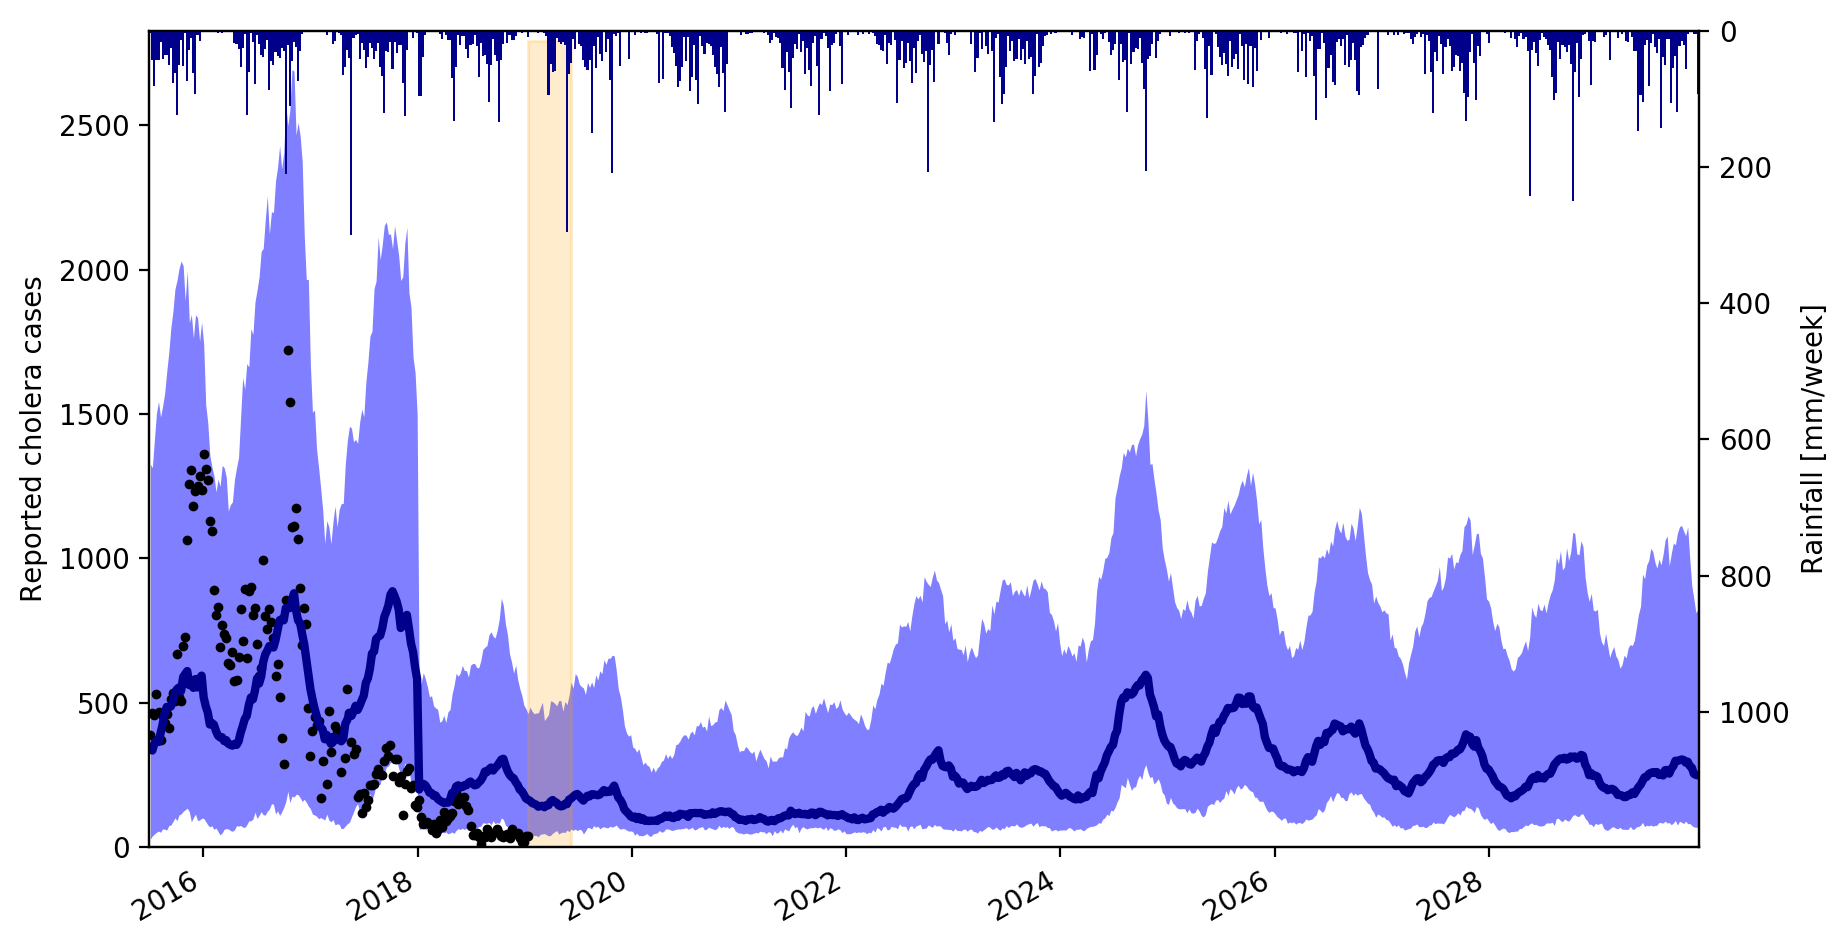

In [465]:
to_plot = all_data_vacc_mob
plot_all_q50 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

plot_all_q05 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

plot_all_q95 =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

for dp in dept_avail:
            plot_all_q50[dp] = to_plot[dp]['cases']['q50']
            plot_all_q95[dp] = to_plot[dp]['cases']['q95']
            plot_all_q05[dp] = to_plot[dp]['cases']['q05']

plot_all = pd.concat([plot_all_q05.sum(axis=1), plot_all_q50.sum(axis=1), plot_all_q95.sum(axis=1)], axis = 1, keys = ['q05', 'q50', 'q95'])


ti = input_parameters['t_start']
ti = datetime.date(2015,7,1)
tf = input_parameters['t_end']
tf = t_for

fig, axes = plt.subplots(1, 1, figsize=(10,6), squeeze = True, dpi = 200);
fig.patch.set_facecolor('white')
axt =  axes.twinx()
axes.plot(cases.sum(axis=1)[t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=5 ) 
axes.fill_between(plot_all['q05'][ti:tf].index, plot_all['q05'][ti:tf], plot_all['q95'][ti:tf], alpha = .5, color = 'blue', linewidth = 0)
axes.plot(plot_all['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 3, color = 'darkblue')
axt.bar(pd.date_range(ti,tf, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[ti:tf], label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

axes.set_ylim(0)
axt.set_ylim(4*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
axes.set_xlim(ti, tf)

start = mdates.date2num(scenario.t_vacc_start['Centre'])
end = mdates.date2num(scenario.t_vacc_end['Grande_Anse'])
end = mdates.date2num(scenario.t_vacc_end['Artibonite']) # For S2


width = end - start
rect = Rectangle((start, 0), width, 100+max(plot_all['q95'][ti:tf]), color='orange', alpha= 0.1)
axes.add_patch(rect) 
axes.add_artist(rect)
rx, ry = rect.get_xy()
cx = rx + rect.get_width()/2.0
cy = ry + rect.get_height()/1.5
    
#fig.tight_layout()
fig.autofmt_xdate()
axt.set_ylabel('Rainfall [mm/week]')
axes.set_ylabel('Reported cholera cases')

### Save results !

In [284]:
to_save = all_data#_vacc_mob
#scenario_str = 'S0'
save_result(all_data, scenario_str)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


# PLOT FOR PRESENTATION

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


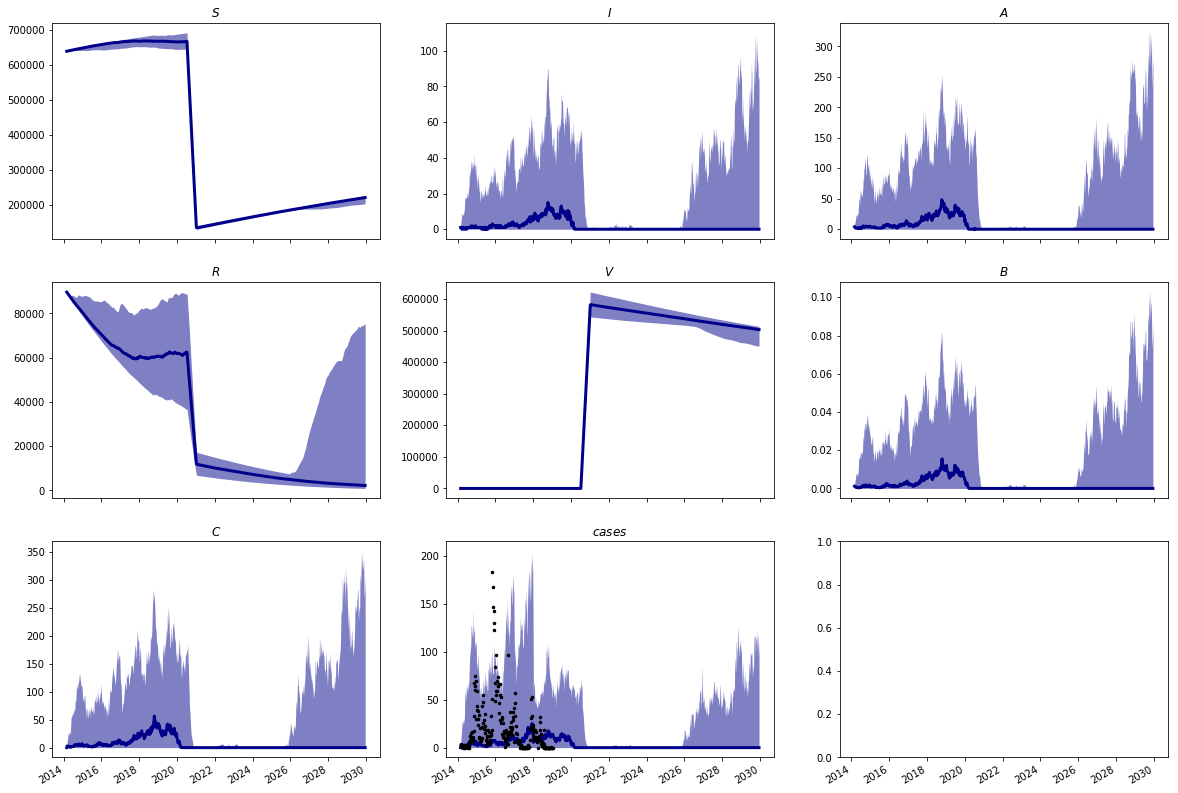

In [432]:
dp = 'Nord-Ouest'
ti = input_parameters['t_start']
tf = input_parameters['t_end']
tf = t_for
data_to_summarize = all_data_vacc_mob

ri_comp = ['RI1', 'RI2', 'RI3']
ra_comp = ['RA1', 'RA2', 'RA3']

data_summary = {}
data_summary['S'] = data_to_summarize[dp]['S']
data_summary['I'] = data_to_summarize[dp]['I']
data_summary['A'] = data_to_summarize[dp]['A']
data_summary['R'] =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = ['q05', 'mean', 'q50', 'q95'])
data_summary['V'] =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = ['q05', 'mean', 'q50', 'q95'])
                                                              
data_summary['B'] = data_to_summarize[dp]['B']
data_summary['C'] = data_to_summarize[dp]['C']
data_summary['cases'] = data_to_summarize[dp]['cases']


for i, comp in enumerate(compartments):
    if 'V' in comp:
        data_summary['V'] += data_to_summarize[dp][comp]
    if comp in ri_comp or comp in ra_comp:
        data_summary['R'] += data_to_summarize[dp][comp]




fig, axes = plt.subplots(3, 3, figsize=(20,15), squeeze = True, sharex = True);
axes = axes.flatten();
i = 0
for key, value in data_summary.items():
    axes[i].fill_between(data_summary[key]['q05'][ti:tf].index, 
                         data_summary[key]['q05'][ti:tf], 
                         data_summary[key]['q95'][ti:tf], alpha = .5, color = 'darkblue', linewidth = 0)
    axes[i].plot(data_summary[key]['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 3, color = 'darkblue')
    if key == 'cases':
        axes[i].plot(cases[dp][ti:tf], marker='.', linestyle='-',color='k', linewidth=0, markersize=5 ) 




    axes[i].set_title('$' + key + '$')
    i += 1
    #axes[i].legend()
    #axes[i].set_ylim(0)
fig.autofmt_xdate()

